# SVM and SVM with Kernals 

This tutorial is adapted from the Notebook Community, with minor updates due to package version changes.
https://notebook.community/steinam/teacher/jup_notebooks/data-science-ipython-notebooks-master/scikit-learn/scikit-learn-svm



In [1]:
# Standard library imports
import os
import warnings

# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact
from mpl_toolkits import mplot3d
from scipy import stats
from sklearn.datasets import make_blobs, make_circles
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix,
                             log_loss, precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

# Configuration and settings
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline


## Support Vector Machine Classifier
Support Vector Machines (SVMs) are a powerful supervised learning algorithm used for classification or for regression. SVMs draw a boundary between clusters of data.  SVMs attempt to maximize the margin between sets of points.  Many lines can be drawn to separate the points above:

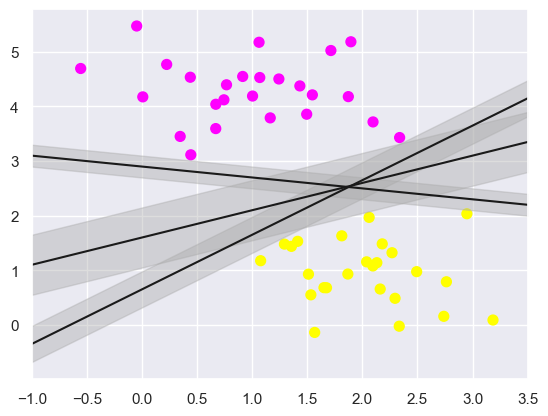

In [2]:
# (old version) from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
            #generates 50 samples divided into 2 clusters, with a standard deviation of 0.60 for each cluster
            #The random_state parameter ensures reproducibility of the dataset
        
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

# Draw three lines that couple separate the data
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Fit the model

In [3]:
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(kernel='linear')

In [4]:
# plot the boundary
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

In the following plot the dashed lines touch a couple of the points known as support vectors, which are stored in the support_vectors_ attribute of the classifier:

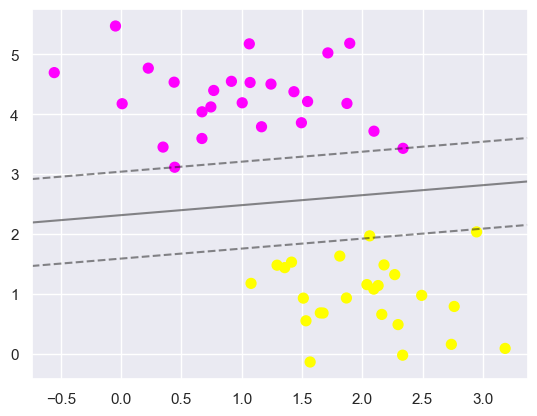

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

Use IPython's interact functionality to explore how the distribution of points affects the support vectors and the discriminative fit:

In [6]:
# (old version) from IPython.html.widgets import interact
def plot_svm(N=100):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 200], kernel='linear');

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

## Support Vector Machine with Kernels Classifier
Kernels are useful when the decision boundary is not linear.  A Kernel is some functional transformation of the input data.  SVMs have clever tricks to ensure kernel calculations are efficient.  In the example below, a linear boundary is not useful in separating the groups of points:

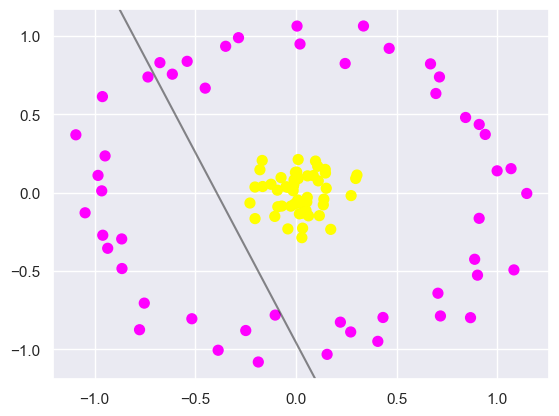

In [7]:
# (old version) from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

A simple model that could be useful is a radial basis function:

In [8]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))


def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

In three dimensions, there is a clear separation between the data.  Run the SVM with the rbf kernel:

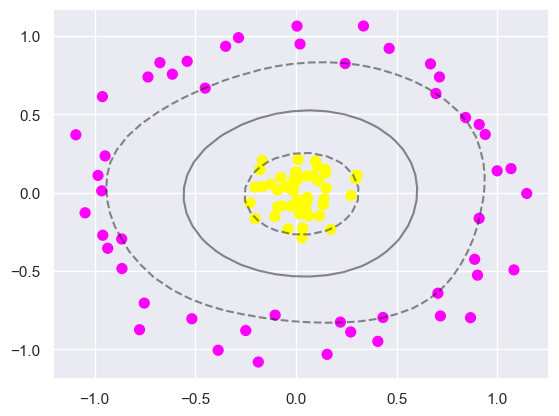

In [9]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

# Datasets

In [10]:
current_path = os.getcwd()
print("The current working directory is:", current_path)

The current working directory is: /Users/anhdang/Documents/Github/COS30082-AppliedML/lab04/SVM with Kernals


In [11]:
# Load the dataset
dataset = pd.read_csv('Titanic-Dataset.csv')

In [12]:
def preprocessing(dataset):
    
    # Convert 'Sex' to numerical
    label_encoder = LabelEncoder()
    dataset['Sex'] = label_encoder.fit_transform(dataset['Sex'])
    
    # Fill missing values
    dataset["Age"].fillna(dataset["Age"].median(skipna=True), inplace=True)
    dataset["Embarked"].fillna(dataset['Embarked'].value_counts().idxmax(), inplace=True)
    
    # Adding new column to check if passenger is a child
    dataset['IsChild'] = np.where(dataset['Age']<=16, 1, 0)
    
    print(dataset.isnull().sum())
    
    ## Create categorical variable for traveling alone
    dataset['TravelAlone']=np.where((dataset["SibSp"]+dataset["Parch"])>0, 0, 1)
    dataset.drop('SibSp', axis=1, inplace=True)
    dataset.drop('Parch', axis=1, inplace=True)
    
    # Create categorical variables and drop some variables
    dataset=pd.get_dummies(dataset, columns=["Pclass","Embarked"])
    
    # Convert True/False values to 0/1 for Embarked
    dataset['Embarked_C'] = dataset['Embarked_C'].astype(int)
    dataset['Embarked_Q'] = dataset['Embarked_Q'].astype(int)
    dataset['Embarked_S'] = dataset['Embarked_S'].astype(int)
    
    # Convert True/False values to 0/1 for Pclass
    dataset['Pclass_1'] = dataset['Pclass_1'].astype(int)
    dataset['Pclass_2'] = dataset['Pclass_2'].astype(int)
    dataset['Pclass_3'] = dataset['Pclass_3'].astype(int)

    # Drop the columns
    dataset.drop(['Cabin','PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    
    print(dataset.head(5))  
    return dataset


In [13]:
raw_dataset = dataset.copy()
clean_dataset = preprocessing(raw_dataset)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
IsChild          0
dtype: int64
   Survived  Sex   Age     Fare  IsChild  TravelAlone  Pclass_1  Pclass_2  \
0         0    1  22.0   7.2500        0            0         0         0   
1         1    0  38.0  71.2833        0            0         1         0   
2         1    0  26.0   7.9250        0            1         0         0   
3         1    0  35.0  53.1000        0            0         1         0   
4         0    1  35.0   8.0500        0            1         0         0   

   Pclass_3  Embarked_C  Embarked_Q  Embarked_S  
0         1           0           0           1  
1         0           1           0           0  
2         1           0           0           1  
3         0           0           0           1  
4         1           0    

# Models

In [19]:
class ClassificationTrainer:
    """
    A class for training a Logistic Regression model with automated feature selection and hyperparameter tuning.
    """

    def __init__(self, dataset, target_column='Survived', test_size=0.2, random_state=42, max_iter=1000, cv_splits=5, model_type='logistic_regression'):
        """
        Initializes the trainer with the dataset and training parameters.
        """

        self.dataset = dataset
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state
        self.max_iter = max_iter
        self.cv_splits = cv_splits
        self.model_type = model_type
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.selected_features = []
        self.grid_search = None

    def _find_best_features(self):
        """
        Identifies the best features for the Logistic Regression model using Recursive Feature Elimination.
        """

        columns = self.dataset.columns.tolist()
        predictors = [column for column in columns if column != self.target_column]

        X = self.dataset[predictors].values
        y = self.dataset[self.target_column].values.ravel()

        model = LogisticRegression(max_iter=self.max_iter, solver='liblinear')
        rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
        rfecv.fit(X, y)

        print(f"Optimal number of features: {rfecv.n_features_}")
        self.selected_features = [predictors[i] for i in range(len(predictors)) if rfecv.support_[i]]
        print(f'Selected features: {self.selected_features}')

        self._split_dataset()

    def _split_dataset(self):
        """
        Splits the dataset into training and testing sets based on the selected features.
        """
        X_selected = self.dataset[self.selected_features]
        y = self.dataset[self.target_column].values.ravel()

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_selected, y, test_size=self.test_size, random_state=self.random_state
        )

    def _train_model(self):
        """
        Trains the selected model. For logistic regression, GridSearchCV is used for hyperparameter tuning.
        For SVM, the model is trained directly without hyperparameter tuning.
        """
        if self.model_type == 'logistic_regression':
            model = LogisticRegression(solver='liblinear', max_iter=self.max_iter, random_state=self.random_state)
            param_grid = {
                'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                'model__penalty': ['l1', 'l2']
            }
            pipeline = Pipeline([
                ('model', model)
            ])
            cv_strategy = StratifiedKFold(n_splits=self.cv_splits, shuffle=True, random_state=self.random_state)
            self.grid_search = GridSearchCV(pipeline, param_grid, cv=cv_strategy, scoring='accuracy', verbose=1)
            self.grid_search.fit(self.X_train, self.y_train)
            print(f"Best parameters for logistic regression: {self.grid_search.best_params_}")
        elif self.model_type == 'svm':
            self.model = SVC(kernel='linear', probability=True, random_state=self.random_state)
            self.model.fit(self.X_train, self.y_train)
            print("SVM model trained without hyperparameter tuning.")
        else:
            raise ValueError("Unsupported model type. Choose 'logistic_regression' or 'svm'.")



    def _evaluate_model(self):
        """
        Evaluates the model's performance on the test set and prints metrics.
        Differentiates between logistic regression and SVM for evaluation due to the
        training approach (GridSearchCV for logistic regression, direct training for SVM).
        """
        # Determine which model to use for predictions based on the model_type
        if self.model_type == 'logistic_regression':
            y_pred = self.grid_search.predict(self.X_test)
            y_pred_proba = self.grid_search.predict_proba(self.X_test)[:, 1]
        elif self.model_type == 'svm':
            y_pred = self.model.predict(self.X_test)
            y_pred_proba = self.model.predict_proba(self.X_test)[:, 1] if hasattr(self.model, "predict_proba") else None
        else:
            raise ValueError("Model type not supported for evaluation.")

        # Calculate evaluation metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        roc_auc = roc_auc_score(self.y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

        # Print evaluation metrics
        print(f"Accuracy on test set: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Confusion Matrix:\n{confusion_matrix(self.y_test, y_pred)}")
        print(f"Recall: {recall:.2f}")
        print(f"ROC AUC score on test set: {roc_auc}")
        print("\nClassification Report:\n", classification_report(self.y_test, y_pred))


    def train(self):
        """
        Public method to train the model and evaluate its performance.
        """

        if not self.X_train or not self.y_train:
            print("Dataset not prepared for training. Finding best features first.")
            self._find_best_features()
        self._train_model()

    def evaluate(self):
        self._evaluate_model()

    def predict(self, X_new):
        """
        Makes predictions on new data using the trained model.
        """
        # Checking model type and if the model is trained
        if self.model_type == 'logistic_regression':
            if self.grid_search is None:
                print("Logistic regression model is not trained yet. Please train the model before making predictions.")
                return []

        elif self.model_type == 'svm':
            if self.model is None:
                print("SVM model is not trained yet. Please train the model before making predictions.")
                return []
        else:
            print("Unsupported model type.")
            return []

        # Ensure selected features are identified
        if not self.selected_features:
            print("Selected features are not identified. Please check the model training process.")
            return []

        # Processing X_new to ensure it only contains the selected features
        if set(self.selected_features).issubset(X_new.columns):
            X_new_selected = X_new[self.selected_features]
        else:
            print("Input data does not contain all the required features.")
            return []

        # Making predictions based on the model type
        predictions = None
        if self.model_type == 'logistic_regression':
            predictions = self.grid_search.predict(X_new_selected)
        elif self.model_type == 'svm':
            predictions = self.model.predict(X_new_selected)

        return predictions


In [23]:
model = ClassificationTrainer(clean_dataset, 
                              target_column='Survived', 
                              test_size=0.5, 
                              random_state=42, 
                              max_iter=1000, 
                              cv_splits=5,
                              model_type='svm')
model.train()
model.evaluate()

Dataset not prepared for training. Finding best features first.
Optimal number of features: 11
Selected features: ['Sex', 'Age', 'Fare', 'IsChild', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
SVM model trained without hyperparameter tuning.
Accuracy on test set: 0.79
Precision: 0.76
Confusion Matrix:
[[227  40]
 [ 54 125]]
Recall: 0.70
ROC AUC score on test set: 0.8457096227481012

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       267
           1       0.76      0.70      0.73       179

    accuracy                           0.79       446
   macro avg       0.78      0.77      0.78       446
weighted avg       0.79      0.79      0.79       446



In [24]:
dummy_data = {
    'PassengerId': [1000, 1001, 1002],
    'Pclass': [1, 3, 2],
    'Name': ['John Doe', 'Jane Doe', 'Alex Doe'],
    'Sex': ['male', 'female', 'female'],
    'Age': [22, 38, np.nan],
    'SibSp': [1, 1, 0],
    'Parch': [0, 2, 0],
    'Ticket': ['A/5 21171', 'PC 17599', 'STON/O2. 3101282'],
    'Fare': [7.25, 71.2833, 15.0458],
    'Cabin': [np.nan, 'C85', np.nan],
    'Embarked': ['S', 'C', 'Q']
}

dummy_df = pd.DataFrame(dummy_data)

processed_dummy_df = preprocessing(dummy_df)

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          2
Embarked       0
IsChild        0
dtype: int64
   Sex   Age     Fare  IsChild  TravelAlone  Pclass_1  Pclass_2  Pclass_3  \
0    1  22.0   7.2500        0            0         1         0         0   
1    0  38.0  71.2833        0            0         0         0         1   
2    0  30.0  15.0458        0            1         0         1         0   

   Embarked_C  Embarked_Q  Embarked_S  
0           0           0           1  
1           1           0           0  
2           0           1           0  


In [25]:
# Displaying predictions in a readable format
dummy_prediction = model.predict(processed_dummy_df)

for i, pred in enumerate(dummy_prediction):
    print(f"Person {i+1} prediction: {'Survived' if pred == 1 else 'Not survived'}")

Person 1 prediction: Not survived
Person 2 prediction: Survived
Person 3 prediction: Survived
